Ukol 2.

In [1]:
import numpy as np 
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.shape

(52500, 1025)

In [3]:
print(df.head())

   pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  pix10  ...  pix1016  \
0     0     0     0     0     0     0     0     0     0      0  ...        0   
1     1     1     1     1     1     1     1     1     1      1  ...        1   
2     1     1     1     1     1     1     1     1     1      1  ...        1   
3     0     0     0     0     0     0     0     0     0      0  ...        0   
4     1     1     1     1     1     1     1     1     1      1  ...        1   

   pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  pix1023  pix1024  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        1   
2        1        1        1        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        1        1        1        1        1        1        1        1   

   label  
0      3  
1      3  
2      7  
3      9  
4

In [4]:
rd_seed = 123
from sklearn.model_selection import train_test_split

Xdata = df.drop('label', axis=1)
ydata = df["label"]
Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size = 0.4, random_state=rd_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.5, random_state=rd_seed)

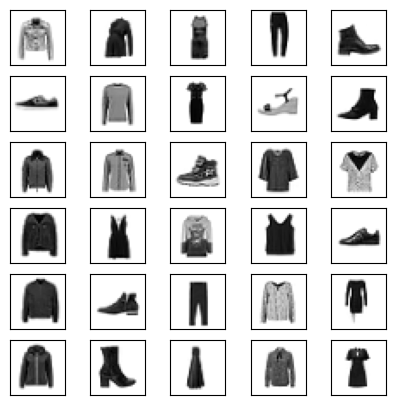

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(Xtrain.iloc[i, :]).reshape(32,32), cmap=plt.cm.binary)

Data, se kterými budu dále pracovat, jsou tedy černobílé obrázky oblečení či obuvi. Obrázky mají 32 x 32 pixelů což dává dohromady 1024 příznaků - pixelů. Příznaky nabývají hodnot od 0 do 255, číslo vyjadřuje odstím šedé. 

In [6]:
print(ydata.unique())

[3 7 9 5 1 6 0 4 8 2]


Z tohohle vidíme, že v tomto úkolu budeme přiřazocat obrázky do 10 různých kategorií.

1. Dopředná neuronová síť

torch.Size([32, 1, 32, 32]) torch.Size([32, 10])


2. Konvoluční neuronová síť

Myslím si, že konvoluční neuronová síť bude pro tento typ problému lepší než síť klasická, protože obsahuje méně parametrů a dá se rychleji naučit.

Nejprve jsem data převedla do formátu tenzoru, poté vytvořila dávky na dávkové učení a nakonec se zkusila podívat jestli to proběhlo v pořádku.

In [179]:
Xtrain_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_t = torch.utils.data.TensorDataset(torch.tensor(Xval.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
Xtest_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))

In [180]:
training_loader = torch.utils.data.DataLoader(Xtrain_t, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(Xval_t, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

In [181]:
dataiter = iter(training_loader)
images,labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 32, 32])
torch.Size([32])


Teďka sestavím první model CNN, bude mít:
- dvě vrstvy s RELU a max poolingem
- jednu fully connected vrstvu bez aktivační fce, 10 neuronů 

In [10]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim =1)
        x = self.fco(x)
        return x       
# outputs = model(images)
# print(images.shape, outputs.shape)

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()

# with torch.no_grad():
#     loss = loss_fn(outputs, labels)
    # print('Total loss for this batch: {}'.format(loss.item()))

In [16]:
optimizer2 = torch.optim.Adagrad(model.parameters())

ValueError: Attempted to use an uninitialized parameter in <built-in method is_complex of type object at 0x00007FFCC2A889E0>. This error happens when you are using a `LazyModule` or explicitly manipulating `torch.nn.parameter.UninitializedParameter` objects. When using LazyModules Call `forward` with a dummy batch to initialize the parameters before calling torch functions

In [ ]:
optimizer3 = torch.optim.RMSprop(model.parameters())

In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyConvNet().to(device)
optimizer1 = torch.optim.Adam(model.parameters())
def train_epoch(model, loss_fn, optimizer, training_loader):
    running_loss = 0.
    correct = 0
    for data in tqdm(training_loader, total = len(training_loader)):
        input, label = data
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output,label)
        loss.backward()
        optimizer.step()
        last_mean_loss = loss.item()
        running_loss += last_mean_loss * input.shape[0]
    return running_loss/len(Xtrain_t)
loss1 = train_epoch(model, loss_fn, optimizer1, training_loader)
print(loss1)
del model
torch.cuda.empty_cache()


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [01:09<00:00, 14.16it/s]

1.205225533954681


In [27]:
loss1 = train_epoch(model, loss_fn, optimizer1, training_loader)
print(loss1)

100%|██████████| 985/985 [00:17<00:00, 56.70it/s] 

20.50448337736584


In [77]:
loss2 = train_epoch(model, loss_fn, optimizer2, training_loader)
print(loss2)

100%|██████████| 985/985 [01:54<00:00,  8.57it/s]

0.8769049557579888


In [78]:
loss3 = train_epoch(model, loss_fn, optimizer3, training_loader)
print(loss3)

100%|██████████| 985/985 [02:12<00:00,  7.43it/s]

251.3120121112324


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyConvNet().to(device)
optimizer1 = torch.optim.Adam(model.parameters())
def train_more_epochs(num_epochs, training_loader, optimizer, model, loss_fn):
    epochs = []
    train_loss = []
    validation_loss = []    
    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_epoch(model, loss_fn, optimizer, training_loader)
        model.train(False)

        running_loss_val = 0.0
        correct_val = 0
        for i, data_val in enumerate(validation_loader):
            inputs_val, labels_val = data_val
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            with torch.no_grad():
                outputs_val = model(inputs_val)
                loss_val = loss_fn(outputs_val, labels_val)
            running_loss_val += loss_val * inputs_val.shape[0]
            # count the correctly classified samoples
            correct_val += (outputs_val.argmax(1) == labels_val).float().sum()
        # Get average loss and accuraccy
        avg_loss_val = running_loss_val / len(Xval_t)
        acc_val = correct_val / len(Xval_t)

        epochs.append(epoch)
        validation_loss.append(avg_loss_val)
        train_loss.append(avg_loss)

        # Report progress
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_loss_val:.3f}, accuraccy: {acc_val:.3f}")
        #return epochs, validation_loss, train_loss
    epochs = np.array(epochs)
    validation_loss = np.array(validation_loss)
    plt.plot(epochs,train_loss, '.-', markersize = 10, label='Train loss')
    plt.plot(epochs,validation_loss, '.-', markersize = 10, label='Validation loss')
    plt.plot([epochs[np.argmin(validation_loss)]], [validation_loss[np.argmin(validation_loss)]],'x', color = 'red', markersize = 10, label='Best val loss')
    plt.legend()
    plt.show()

train_more_epochs(25, training_loader,optimizer1,model, loss_fn)
del model
torch.cuda.empty_cache()

EPOCH 1:


100%|██████████| 985/985 [00:08<00:00, 118.86it/s]


TRAIN loss: 1.043, VALIDATION loss: 0.748, accuraccy: 0.744
EPOCH 2:


 53%|█████▎    | 525/985 [00:04<00:03, 120.00it/s]


KeyboardInterrupt: 

EPOCH 1:


100%|██████████| 985/985 [01:32<00:00, 10.61it/s]


TRAIN loss: 0.565, VALIDATION loss: 0.643, accuraccy: 0.771
EPOCH 2:


100%|██████████| 985/985 [02:31<00:00,  6.50it/s]


TRAIN loss: 0.543, VALIDATION loss: 0.635, accuraccy: 0.777


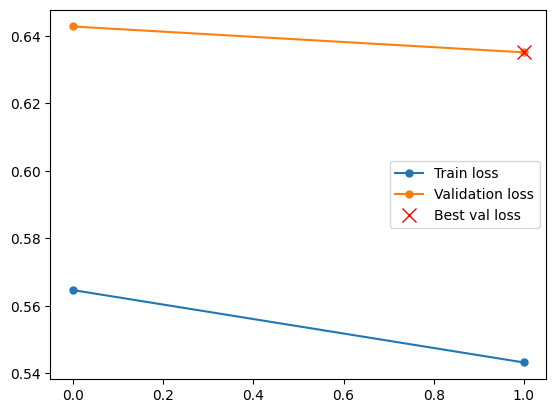

In [89]:
train_more_epochs(2, training_loader,optimizer2,model, loss_fn)

EPOCH 1:


100%|██████████| 985/985 [00:57<00:00, 17.06it/s]


TRAIN loss: 0.527, VALIDATION loss: 0.621, accuraccy: 0.782
EPOCH 2:


100%|██████████| 985/985 [01:40<00:00,  9.76it/s]


TRAIN loss: 0.504, VALIDATION loss: 0.618, accuraccy: 0.788
EPOCH 3:


100%|██████████| 985/985 [02:16<00:00,  7.21it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.608, accuraccy: 0.791
EPOCH 4:


100%|██████████| 985/985 [02:13<00:00,  7.38it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.612, accuraccy: 0.788
EPOCH 5:


100%|██████████| 985/985 [02:01<00:00,  8.08it/s]


TRAIN loss: 0.462, VALIDATION loss: 0.610, accuraccy: 0.792
EPOCH 6:


100%|██████████| 985/985 [02:17<00:00,  7.16it/s]


TRAIN loss: 0.452, VALIDATION loss: 0.611, accuraccy: 0.792
EPOCH 7:


100%|██████████| 985/985 [01:55<00:00,  8.54it/s]


TRAIN loss: 0.439, VALIDATION loss: 0.614, accuraccy: 0.796
EPOCH 8:


100%|██████████| 985/985 [01:54<00:00,  8.58it/s]


TRAIN loss: 0.428, VALIDATION loss: 0.611, accuraccy: 0.796
EPOCH 9:


100%|██████████| 985/985 [02:04<00:00,  7.92it/s]


TRAIN loss: 0.418, VALIDATION loss: 0.608, accuraccy: 0.797
EPOCH 10:


100%|██████████| 985/985 [02:03<00:00,  7.98it/s]


TRAIN loss: 0.408, VALIDATION loss: 0.613, accuraccy: 0.796


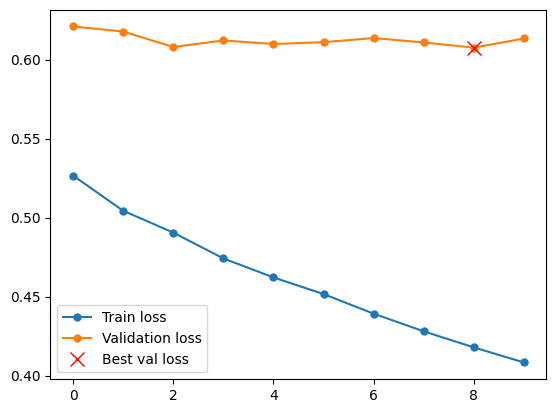

In [90]:
train_more_epochs(10, training_loader,optimizer2,model, loss_fn)

In [14]:
train_more_epochs(25, training_loader,optimizer1,model, loss_fn)
del model
torch.cuda.empty_cache()

NameError: name 'optimizer1' is not defined

In [96]:
from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler().fit(Xtrain)
Xtrain_sc = st_scaler.transform(Xtrain)
Xval_sc = st_scaler.transform(Xval)
Xtrain_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain_sc.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xval_sc.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
#Xtest_sc_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))
training_loader_sc = torch.utils.data.DataLoader(Xtrain_sc_t, batch_size=32, shuffle=True)
validation_loader_sc = torch.utils.data.DataLoader(Xval_sc_t, batch_size=128, shuffle=False)
#test_loader_sc = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

In [99]:
train_more_epochs(10, training_loader_sc,optimizer1,model, loss_fn)

EPOCH 1:


100%|██████████| 985/985 [01:24<00:00, 11.68it/s]


TRAIN loss: 1.154, VALIDATION loss: 14.335, accuraccy: 0.555
EPOCH 2:


100%|██████████| 985/985 [01:57<00:00,  8.36it/s]


TRAIN loss: 0.776, VALIDATION loss: 14.589, accuraccy: 0.622
EPOCH 3:


100%|██████████| 985/985 [02:14<00:00,  7.35it/s]


TRAIN loss: 0.663, VALIDATION loss: 22.316, accuraccy: 0.605
EPOCH 4:


100%|██████████| 985/985 [03:13<00:00,  5.08it/s]


TRAIN loss: 0.594, VALIDATION loss: 21.696, accuraccy: 0.634
EPOCH 5:


 95%|█████████▌| 940/985 [01:17<00:03, 12.15it/s]


KeyboardInterrupt: 

In [98]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler().fit(Xtrain)
Xtrain_mm = mm_scaler.transform(Xtrain)
Xval_mm = mm_scaler.transform(Xval)
Xtrain_mm_t = torch.utils.data.TensorDataset(torch.tensor(Xtrain_mm.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytrain)).type(torch.long))
Xval_mm_t = torch.utils.data.TensorDataset(torch.tensor(Xval_mm.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(yval)).type(torch.long))
#Xtest_t = torch.utils.data.TensorDataset(torch.tensor(Xtest.values.reshape(-1, 1, 32, 32), dtype=torch.float32), torch.Tensor(np.array(ytest)).type(torch.long))
training_loader_mm = torch.utils.data.DataLoader(Xtrain_mm_t, batch_size=32, shuffle=True)
validation_loader_mm = torch.utils.data.DataLoader(Xval_mm_t, batch_size=128, shuffle=False)
#test_loader = torch.utils.data.DataLoader(Xtest_t, batch_size=128, shuffle=False)

In [100]:
train_more_epochs(10, training_loader_mm,optimizer1,model, loss_fn)

EPOCH 1:


100%|██████████| 985/985 [02:30<00:00,  6.53it/s]


TRAIN loss: 0.579, VALIDATION loss: 55.507, accuraccy: 0.716
EPOCH 2:


100%|██████████| 985/985 [02:05<00:00,  7.84it/s]


TRAIN loss: 0.453, VALIDATION loss: 63.964, accuraccy: 0.737
EPOCH 3:


100%|██████████| 985/985 [02:21<00:00,  6.96it/s]


TRAIN loss: 0.414, VALIDATION loss: 58.115, accuraccy: 0.734
EPOCH 4:


100%|██████████| 985/985 [02:43<00:00,  6.03it/s]


TRAIN loss: 0.386, VALIDATION loss: 63.216, accuraccy: 0.709
EPOCH 5:


100%|██████████| 985/985 [02:07<00:00,  7.75it/s]


TRAIN loss: 0.363, VALIDATION loss: 64.921, accuraccy: 0.708
EPOCH 6:


100%|██████████| 985/985 [02:14<00:00,  7.32it/s]


TRAIN loss: 0.346, VALIDATION loss: 88.980, accuraccy: 0.646
EPOCH 7:


  2%|▏         | 16/985 [00:02<02:41,  5.99it/s]


KeyboardInterrupt: 

In [120]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=5)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=5)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(10)
        #self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = self.fco1(x)
        #x = x.flatten(start_dim =1)
        #x = self.fco2(x)
        return x
    
model2 = Model2()       
outputs = model2(images)
print(images.shape, outputs.shape)

torch.Size([32, 1, 32, 32]) torch.Size([32, 10])


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [117]:
train_epoch(model, loss_fn, optimizer2, training_loader)

100%|██████████| 985/985 [02:06<00:00,  7.77it/s]


1.0989040410026671

In [121]:
train_epoch(model2, loss_fn, optimizer2, training_loader)

100%|██████████| 985/985 [03:54<00:00,  4.21it/s]


6.217289507669116

In [24]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(100)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv1_drop(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        x = (self.fco2(x))
        return x
    
model3 = Model3()       
#outputs = model2(images)
#print(images.shape, outputs.shape)

In [188]:
optimizer11 = torch.optim.Adam(model3.parameters())
train_more_epochs(25,training_loader,optimizer11,model3,loss_fn)

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]

100%|██████████| 985/985 [01:20<00:00, 12.23it/s]


TRAIN loss: 0.985, VALIDATION loss: 0.608, accuraccy: 0.785
EPOCH 2:


 55%|█████▌    | 546/985 [00:46<00:37, 11.69it/s]


KeyboardInterrupt: 

In [190]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        #self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=10,kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.conv4 = nn.Conv2d(in_channels=10,out_channels=8,kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fco1 = nn.LazyLinear(100)
        self.fco2 = nn.LazyLinear(10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        #x = self.conv1_drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim =1)
        x = F.relu(self.fco1(x))
        x = F.softmax(self.fco2(x))
        return x
#model4 = Model4().to(device)
model4 = Model4()       
#utputs = model2(images)
#print(images.shape, outputs.shape)

In [136]:
train_epoch(model3, loss_fn, optimizer2, training_loader)

  0%|          | 0/985 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\3232218555.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fco2(x))
100%|██████████| 985/985 [03:30<00:00,  4.68it/s]


2.3522383128574917

In [132]:
train_epoch(model3, loss_fn, optimizer3, training_loader)

  0%|          | 0/985 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\915719990.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fco2(x))
100%|██████████| 985/985 [02:13<00:00,  7.35it/s]


2.298869356700352

In [191]:
optimizer44 = torch.optim.Adam(model4.parameters())
train_more_epochs(25,training_loader,optimizer44,model4,loss_fn)

EPOCH 1:


  0%|          | 0/985 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\3147007859.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fco2(x))
100%|██████████| 985/985 [01:48<00:00,  9.07it/s]


TRAIN loss: 1.964, VALIDATION loss: 2.061, accuraccy: 0.400
EPOCH 2:


 20%|██        | 200/985 [00:22<01:27,  8.95it/s]


KeyboardInterrupt: 

1. Dopredna NN

In [195]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 16)
        self.fco = nn.Linear(16, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

model01 = MyNet()

# zkusíme tam dát data
outputs = model01(images)
print(images.shape, outputs.shape)

torch.Size([32, 1, 32, 32]) torch.Size([32, 10])


In [196]:
optimizer01 = torch.optim.Adam(model01.parameters())

In [197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model01 = MyNet().to(device)
loss01 = train_epoch(model01, loss_fn, optimizer01, training_loader)
print(loss01)
del model
torch.cuda.empty_cache()

100%|██████████| 985/985 [00:02<00:00, 379.45it/s]

42.27723533073304


In [200]:
def train_more_epochs_es(num_epochs, stop_epochs, model, loss_fn, optimizer, training_loader):
    epochs = []
    train_loss = []
    validation_loss = []    
    best_loss_val = 1000000.
    epochs_from_best = 0

    for epoch in range(num_epochs):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_epoch(model, loss_fn, optimizer, training_loader)
        model.train(False)

        running_loss_val = 0.0
        correct_val = 0
        for i, data_val in enumerate(validation_loader):
            inputs_val, labels_val = data_val
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            with torch.no_grad():
                outputs_val = model(inputs_val)
                loss_val = loss_fn(outputs_val, labels_val)
            running_loss_val += loss_val * inputs_val.shape[0]
            # count the correctly classified samoples
            correct_val += (outputs_val.argmax(1) == labels_val).float().sum()
        # Get average loss and accuraccy
        avg_loss_val = running_loss_val / len(Xval_t)
        acc_val = correct_val / len(Xval_t)

        epochs.append(epoch)
        validation_loss.append(avg_loss_val)
        train_loss.append(avg_loss)

        # Report progress
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_loss_val:.3f}, accuraccy: {acc_val:.3f}")
        #return epochs, validation_loss, train_loss
        
        if avg_loss_val < best_loss_val:
            print("Saving best model")
            best_vloss = avg_loss_val
            model_path = "saves/best_model.pt"
            torch.save(model.state_dict(), model_path)
            epochs_from_best = 0
        else:
            print("No improvement in this epoch.")
            epochs_from_best += 1
        
    # EARLY STOPPING
        if epochs_from_best > stop_epochs:
            print("Early stopping now")
            break

    epochs = np.array(epochs)
    validation_loss = np.array(validation_loss)
    plt.plot(epochs,train_loss, '.-', markersize = 10, label='Train loss')
    plt.plot(epochs,validation_loss, '.-', markersize = 10, label='Validation loss')
    plt.plot([epochs[np.argmin(validation_loss)]], [validation_loss[np.argmin(validation_loss)]],'x', color = 'red', markersize = 10, label='Best val loss')
    plt.legend()
    plt.show()